In [ ]:
!nvidia-smi

Tue Apr 20 12:57:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Importing the libraries

In [ ]:
import glob
import numpy as np
import pandas as pd
import os
import shutil
import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import cv2
import keras
from keras import backend as K

# Importing the dataset

We have taken our dataset from this open-source repository https://github.com/shervinmin/DeepCovid

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls "/content/drive/MyDrive/Covid SS/Dataset1/"

covid  non


In [ ]:
data_path = "/content/drive/MyDrive/Covid SS/Dataset1/"

Setting the size of the image (W,H)

In [ ]:
W = 112
H = 112
label_to_class = {'non': 0,
                  'covid': 1,}

class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name, label_to_class=label_to_class): #read images/labels from directory
    Images = []
    Classes = []

    for label_name in os.listdir(dir_name):
        cls = label_to_class[label_name]

        for img_name in os.listdir('/'.join([dir_name, label_name])):
            img = load_img('/'.join([dir_name, label_name, img_name]), target_size=(W, H))
            img = img_to_array(img)

            Images.append(img)
            Classes.append(cls)

    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)

    return Images, Classes

Images and its respective labels

Here, '0' signifies 'non-covid' images,
      '1' signifies 'covid' images

In [ ]:
Images, Classes = get_images("/content/drive/MyDrive/Covid SS/Dataset1")
Images.shape, Classes.shape

((5184, 112, 112, 3), (5184,))

non 5000 0.9645061728395061


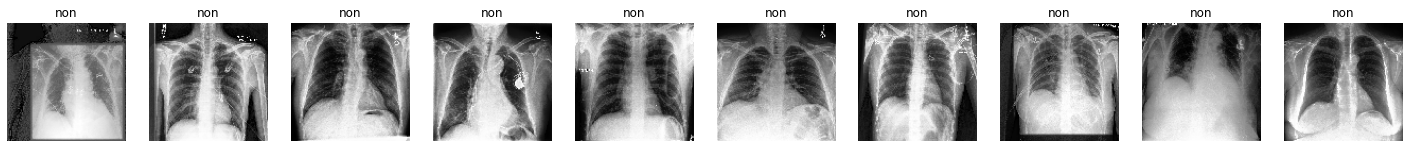

covid 184 0.035493827160493825


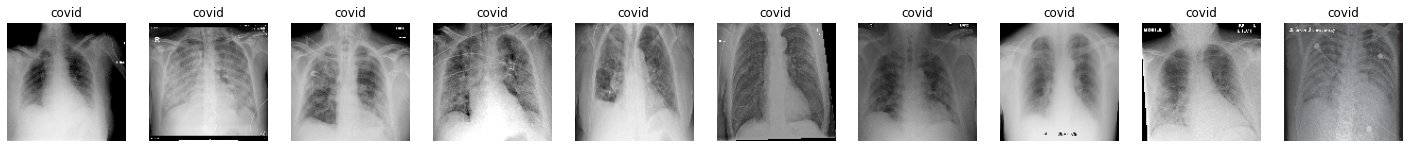

In [ ]:
#visualize images
n_total_images = Images.shape[0]

for target_cls in [0, 1]:

    indices = np.where(Classes == target_cls)[0] #get target class of the images
    n_target_cls = indices.shape[0]
    label = class_to_label[target_cls]
    print(label, n_target_cls, n_target_cls/n_total_images)

    n_cols = 10 # checking 10 images
    fig, axs = plt.subplots(ncols=n_cols, figsize=(25, 3))

    for i in range(n_cols):

        axs[i].imshow(np.uint8(Images[indices[i]]))
        axs[i].axis('off')
        axs[i].set_title(label)

    plt.show()

Our dataset consists of a total of 5184 images, where there are 5000 Non-Covid images and 184 Covid affected lung images.

Here we have splitted the dataset into training and testing sets. 80 % of the data will be assigned to the training set.

In [ ]:
indices_train, indices_test = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, shuffle=False)

x_train = Images[indices_train]
y_train = Classes[indices_train]
x_test = Images[indices_test]
y_test = Classes[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4147, 112, 112, 3), (4147,), (1037, 112, 112, 3), (1037,))

After splitting the dataset, we have 4147 images as our training data and 1037 images as our testing dataset.

In [ ]:
# one-hot encoding
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

y_train.shape, y_test.shape

((4147, 2), (1037, 2))

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4147, 112, 112, 3), (4147, 2), (1037, 112, 112, 3), (1037, 2))

# Image Augmentation

In [ ]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,                       # randomly rotate images in the range
    zoom_range=0.1,                          # Randomly zoom image
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,                     # randomly flip images vertically
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

# Model Building


We have used a ResNet50 architecture which is a variant of the ResNet model, applying the transfer learning approach.

Transfer Learning approach is the reuse of a pre-trained model on a new problem. Here the knowledge of an already trained machine learning model is applied to the different but related problem.

In [ ]:
import os

import copy
import warnings
warnings.filterwarnings('ignore')

import cv2
import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from keras.layers import Conv2D, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.resnet50 import preprocess_input, ResNet50
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf



In [ ]:
def build_model():
    #calling the resnet model
    input_tensor = Input(shape=(W, H, 3))
    resnet50 = ResNet50(
        include_top=False,  #keeping the parameter False to add the layers
        weights='imagenet',
        input_tensor=input_tensor,
    )

    # Adding the layers/fc layer
    top_model = Sequential()
    top_model.add(GlobalAveragePooling2D())
    top_model.add(Dense(n_classes, activation='softmax'))

    # Combining the model and the layers
    model = Model(inputs=resnet50.input, outputs=top_model(resnet50.output))

    # frozen weights
    for layer in model.layers[:-10]:
        layer.trainable = False or isinstance(layer, BatchNormalization)


    return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 118, 118, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 56, 56, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 56, 56, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

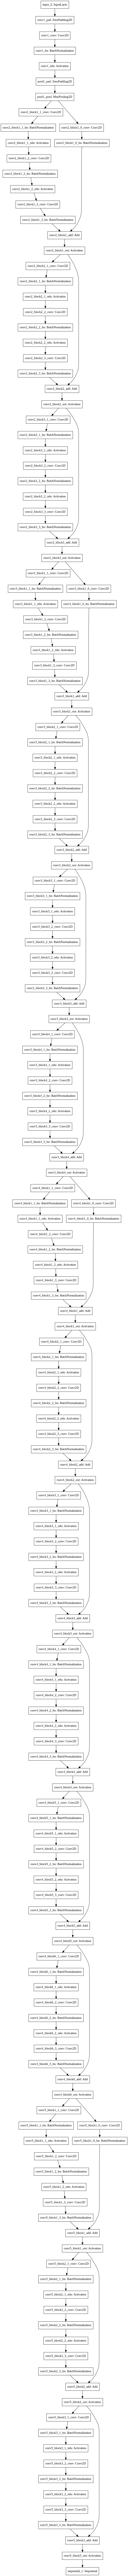

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model)

We will be using the Early Stopping method to stop the training at that epochs where the validation loss increases, keeping the patience 3.

The optimizer used is Adam optimizer.

In [ ]:
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping,ModelCheckpoint

earlystop = EarlyStopping(monitor = 'val_loss',
                          patience = 3,

                           )

check = ModelCheckpoint("model_weights.h5",
                        monitor='val_loss',
                        save_best_only=True,
                        save_weights_only=True,
                        mode='min')

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
#finetuning the model
history = model.fit_generator(
        datagen_train.flow(x_train, y_train, batch_size=32),
        epochs = 100,
        validation_data= datagen_test.flow(x_test, y_test, batch_size=32),
        callbacks=[earlystop, check]
)

Epoch 1/100
130/130 [==============================] - 43s 327ms/step - batch: 64.5000 - size: 31.9000 - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.0081 - val_accuracy: 0.9971
Epoch 2/100
130/130 [==============================] - 41s 319ms/step - batch: 64.5000 - size: 31.9000 - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0174 - val_accuracy: 0.9961
Epoch 3/100
130/130 [==============================] - 42s 322ms/step - batch: 64.5000 - size: 31.9000 - loss: 0.0045 - accuracy: 0.9983 - val_loss: 0.0124 - val_accuracy: 0.9981
Epoch 4/100
130/130 [==============================] - 42s 320ms/step - batch: 64.5000 - size: 31.9000 - loss: 0.0023 - accuracy: 0.9990 - val_loss: 0.0109 - val_accuracy: 0.9961


As you can see our training stops at the 4th epoch due to the early stopping method.

### Accuracy graph

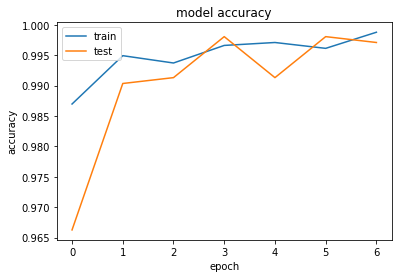

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### Loss graph

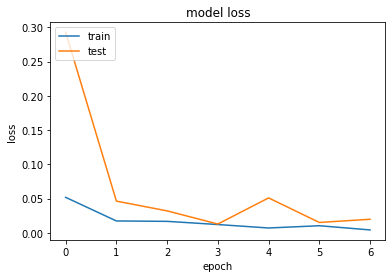

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
acc = history.history['accuracy']
print(sum(acc)/len(acc))

0.9949016485895429


In [ ]:
val_acc = history.history['val_accuracy']
print(sum(val_acc)/len(val_acc))

0.990356811455318


After training the model, we find that our model as an accuracy of 99 %.

To check its validity, we have used a confusion matrix.

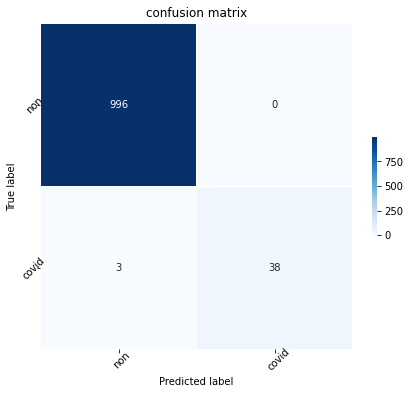

In [ ]:
#plot confusion matrix
import copy
import warnings

x = preprocess_input(copy.deepcopy(x_test))
y_preds = model.predict(x)
y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

As you can see from the confusion matrix, our model can as a high probality of predicting the images succesddfully whether it is a Covid affected lung or not

From the confusion matrix, we can predict the **Precision and Recall**:-

Precsion = TP/ (TP + FP)

Recall  = TP/ (TP + FN)

Our precision value is 0.996 and the recall is 1.

#Grad-CAM - Generating Heatmaps

To check whether the model is able to properly classify between covid and non-covid images, we can visually debug the model using the Grad-CAM approach.

Using Grad-CAM, we can visually validate where our network is looking, verifying that it indeed looking at the correct patterns in the image and activating around those images.

In [ ]:
def superimpose(img, cam):
  #superimpose original image and cam heatmap

    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * .5 + img * .5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return img, heatmap, superimposed_img

In [ ]:
def _plot(model, cam_func, img, cls_true):
  #plot original image, heatmap from cam and superimpose image

    x = np.expand_dims(img, axis=0)
    x = preprocess_input(copy.deepcopy(x))

    #superimpose
    img = np.uint8(img)

    # cam + superimpose
    cls_pred, cam = cam_func(model=model, x=x, layer_name=model.layers[-2].name)
    img, heatmap, superimposed_img = superimpose(img, cam)

    fig, axs = plt.subplots(ncols=3, figsize=(9, 4))

    axs[0].imshow(img)
    axs[0].set_title('original image')
    axs[0].axis('off')

    axs[1].imshow(heatmap)
    axs[1].set_title('heatmap')
    axs[1].axis('off')

    axs[2].imshow(superimposed_img)
    axs[2].set_title('superimposed image')
    axs[2].axis('off')

    plt.suptitle('True label: ' + class_to_label[cls_true] + ' / Predicted label : ' + class_to_label[cls_pred])
    plt.tight_layout()
    plt.show()

In [ ]:
#Grad-CAM function
def grad_cam(model, x, layer_name):

    cls = np.argmax(model.predict(x))

    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    #Get outputs and grads
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([x])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1)) # Passing through GlobalAveragePooling

    cam = np.dot(output, weights) # multiply
    cam = np.maximum(cam, 0)      # Passing through ReLU
    cam /= np.max(cam)            # scale 0 to 1.0

    return cls, cam

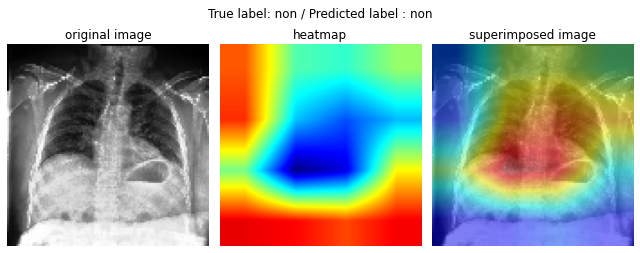

In [ ]:
_plot(model=model, cam_func=grad_cam, img=Images[11], cls_true=Classes[11])

As you can see, original image and the heatmap is superimposed to get the final image, emphasing the model ability to check for patterns and classify it into different classes.

Here, the model is also able to predict the images corectly as 'non'.

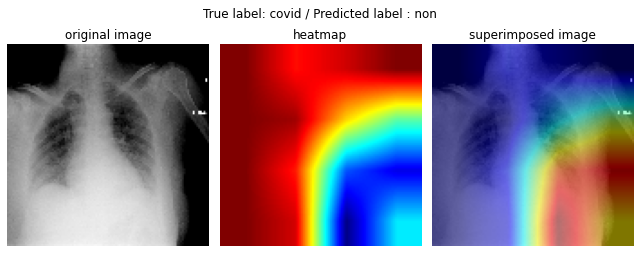

In [ ]:
_plot(model=model, cam_func=grad_cam, img=Images[12], cls_true=Classes[12])

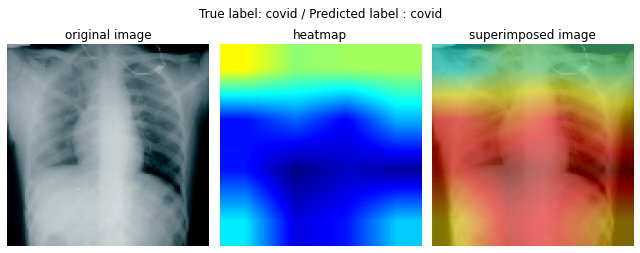

In [ ]:
_plot(model=model, cam_func=grad_cam, img=Images[203], cls_true=Classes[203])

Now we will try the Grad-CAM approach to one of the test data.

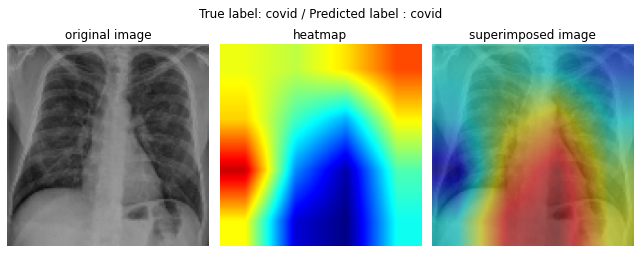

In [ ]:
_plot(model=model, cam_func=grad_cam, img=x_test[65], cls_true=y_test[65])

As you can see the model is able to predict the covid image corretly and also able to generate the heatmap to show the part of the lung that was instrumental in distinguishing between the two classes and showcasing the affected portion.